# Loading the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading the datasets

In [2]:
population=pd.read_csv('Population.csv')
GDP=pd.read_csv('GDP.csv')
Area=pd.read_csv('Area.csv')

# Processing the dataframes in the required format

In [3]:
def process(df):
    
    df=df.drop(df.iloc[:,1:3],axis=1)
    df=df.set_index(['Country Name','Indicator Code']).stack().unstack(level=1).reset_index()
    df=df.rename(columns={'level_1':'Year'})
    df=df.groupby('Country Name').mean()
    df=df.reset_index()
    #df['Year']=pd.to_datetime(df['Year'],format='%Y')
    #df['Year'] = pd.DatetimeIndex(df['Year']).year
    #df=df[df['Year']>1964]
    
    return df
    

Area=process(Area)
GDP=process(GDP)
population=process(population)

In [4]:
Area=Area.rename(columns={'AG.LND.TOTL.K2':'Area'})
population=population.rename(columns={'SP.POP.TOTL':'Population'})
GDP=GDP.rename(columns={'NY.GDP.MKTP.CD':'GDP'})

# Getting the change in energy produced from non-renewable sources

In [5]:
WEC=pd.read_csv('World Energy Consumption.csv')
WEC.head()

,iso_code,country,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,...,solar_elec_per_capita,solar_energy_per_capita,gdp,wind_share_elec,wind_cons_change_pct,wind_share_energy,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_energy_per_capita
0,AFG,Afghanistan,1900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1901,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Afghanistan,1902,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,Afghanistan,1903,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,Afghanistan,1904,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
WEC=WEC[['country','year','coal_prod_change_twh','gas_prod_change_twh','oil_prod_change_twh']]
WEC=WEC[WEC['year']>1964]
WEC.head()

,country,year,coal_prod_change_twh,gas_prod_change_twh,oil_prod_change_twh
65,Afghanistan,1965,0.252,NaN,NaN
66,Afghanistan,1966,0.147,NaN,NaN
67,Afghanistan,1967,-0.090,NaN,NaN
68,Afghanistan,1968,-0.212,NaN,NaN
69,Afghanistan,1969,0.090,NaN,NaN


In [7]:
WEC=WEC.fillna(0)
WEC['energy_prod_change_twh']=WEC['coal_prod_change_twh'] + WEC['gas_prod_change_twh'] + WEC['oil_prod_change_twh']
WEC=WEC[['country','energy_prod_change_twh']]
WEC=WEC.reset_index(drop=True)
WEC.head()

,country,energy_prod_change_twh
0,Afghanistan,0.252
1,Afghanistan,0.147
2,Afghanistan,-0.090
3,Afghanistan,-0.212
4,Afghanistan,0.090


In [8]:
WEC=WEC.groupby('country').mean()
WEC=WEC.round(2)
WEC=WEC.reset_index()
WEC.head()

,country,energy_prod_change_twh
0,Afghanistan,0.16
1,Africa,126.61
2,Albania,0.10
3,Algeria,23.21
4,American Samoa,0.00


In [9]:
WEC=WEC.rename(columns={'country':'Country Name'})
WEC.head()

,Country Name,energy_prod_change_twh
0,Afghanistan,0.16
1,Africa,126.61
2,Albania,0.10
3,Algeria,23.21
4,American Samoa,0.00


# Countries and their renewable energy production %

In [10]:
renewable_energy=pd.read_csv('renewable-share-energy.csv')
renewable_energy.head()

,Entity,Code,Year,Renewables (% sub energy)
0,Africa,NaN,1965,5.526
1,Africa,NaN,1966,5.862
2,Africa,NaN,1967,6.069
3,Africa,NaN,1968,6.730
4,Africa,NaN,1969,7.669


In [11]:
#Data processing for the renewable energy dataframe
#Dropping the code column
#grouping by entity and renameing the column to country
renewable_energy=renewable_energy.drop(['Code','Year'],axis=1)
renewable_energy=renewable_energy.rename(columns={'Entity':'Country Name'})
renewable_energy=renewable_energy.groupby('Country Name').mean('Renewables (% sub energy)')
renewable_energy=renewable_energy.reset_index()
renewable_energy.head()

,Country Name,Renewables (% sub energy)
0,Africa,6.975839
1,Algeria,0.893071
2,Argentina,9.478679
3,Asia Pacific,6.246982
4,Australia,4.861643


# Merging all data to implement correlation analysis

In [12]:
#Insert all the columns with the corresponding country into a single dataframe
from functools import reduce
dfs=[Area,population,GDP]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Country Name'],
                                            how='inner'), dfs).fillna('void')
df_merged.head()

Indicator Code,Country Name,Area,Population,GDP
0,Afghanistan,6.528600e+05,1.869939e+07,7.501027e+09
1,Africa Eastern and Southern,1.476761e+07,3.363310e+08,3.329257e+11
2,Africa Western and Central,9.045960e+06,2.287737e+08,2.359754e+11
3,Albania,2.740000e+04,2.710419e+06,6.882272e+09
4,Algeria,2.381740e+06,2.560932e+07,6.831043e+10


In [13]:
x=df_merged.join(renewable_energy.set_index('Country Name'), on='Country Name')

In [14]:
y=x.join(WEC.set_index('Country Name'),on='Country Name')
y.head()

,Country Name,Area,Population,GDP,Renewables (% sub energy),energy_prod_change_twh
0,Afghanistan,6.528600e+05,1.869939e+07,7.501027e+09,NaN,0.16
1,Africa Eastern and Southern,1.476761e+07,3.363310e+08,3.329257e+11,NaN,NaN
2,Africa Western and Central,9.045960e+06,2.287737e+08,2.359754e+11,NaN,NaN
3,Albania,2.740000e+04,2.710419e+06,6.882272e+09,NaN,0.10
4,Algeria,2.381740e+06,2.560932e+07,6.831043e+10,0.893071,23.21


In [68]:
#df_merged['Indicator Code']
#d={'Country Name':'Africa','Area':23813574.056,'Population':565104729.67,'GDP':568901030293.049}
#df_merged=df_merged.append(d,ignore_index=True)

In [15]:
y=y.dropna()

In [16]:
y1=y.drop('Country Name',axis=1)
y1.head()

,Area,Population,GDP,Renewables (% sub energy),energy_prod_change_twh
4,2.381740e+06,2.560932e+07,6.831043e+10,0.893071,23.21
10,2.736690e+06,3.251555e+07,2.069786e+11,9.478679,9.46
13,7.683110e+06,1.724422e+07,4.656506e+11,4.861643,82.47
14,8.257123e+04,7.862501e+06,1.826247e+11,27.932536,0.00
15,8.300672e+04,7.105890e+06,2.838087e+10,3.124861,9.64


# Correlation analysis to find the best features

In [96]:
corr=y1.corr()
corr.style.background_gradient(cmap='Blues')

,Area,Population,GDP,Renewables (% sub energy),energy_prod_change_twh
Area,1.000000,0.975293,0.972422,-0.014954,0.979083
Population,0.975293,1.000000,0.955984,-0.041666,0.982983
GDP,0.972422,0.955984,1.000000,-0.045854,0.955016
Renewables (% sub energy),-0.014954,-0.041666,-0.045854,1.000000,-0.040167
energy_prod_change_twh,0.979083,0.982983,0.955016,-0.040167,1.000000


# Analysis to gain some insights

In [18]:
#loading world energy consumption data
df1=pd.read_csv('global-fossil-fuel-consumption.csv')
df1.head()

,Entity,Code,Year,Coal (TWh; direct energy),Oil (TWh; direct energy),Gas (TWh; direct energy)
0,World,OWID_WRL,1800,97,0,0
1,World,OWID_WRL,1810,128,0,0
2,World,OWID_WRL,1820,153,0,0
3,World,OWID_WRL,1830,264,0,0
4,World,OWID_WRL,1840,356,0,0


In [19]:
df1=df1.drop(['Code','Coal (TWh; direct energy)','Gas (TWh; direct energy)'],axis=1)
df1.head()

,Entity,Year,Oil (TWh; direct energy)
0,World,1800,0
1,World,1810,0
2,World,1820,0
3,World,1830,0
4,World,1840,0


In [20]:
df1=df1[df1['Year']>1979]
df1.tail()

,Entity,Year,Oil (TWh; direct energy)
67,World,2015,50892
68,World,2016,51920
69,World,2017,52568
70,World,2018,53181
71,World,2019,53620


In [21]:
df1.to_csv('oil_data.csv')

In [22]:
df2=pd.read_csv('oil-proved-reserves.csv')
df2.head()

,Entity,Code,Year,Oil - Proved reserves
0,Africa,NaN,1980,5.343652e+10
1,Africa,NaN,1981,5.628177e+10
2,Africa,NaN,1982,5.827078e+10
3,Africa,NaN,1983,5.803876e+10
4,Africa,NaN,1984,5.776658e+10


In [23]:
#df2=df2.drop('Code',axis=1)
df2=df2[df2['Entity']=='World']
df2=df2[df2['Year']<2020]
df2.tail()

,Entity,Code,Year,Oil - Proved reserves
2326,World,OWID_WRL,2015,1.683903e+12
2327,World,OWID_WRL,2016,1.690281e+12
2328,World,OWID_WRL,2017,1.728171e+12
2329,World,OWID_WRL,2018,1.736144e+12
2330,World,OWID_WRL,2019,1.734811e+12


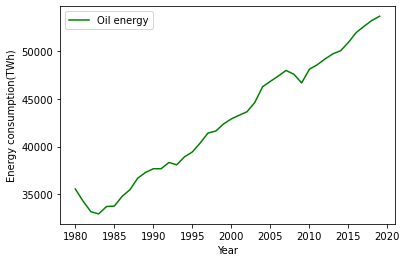

In [26]:
plt.plot(df1['Year'], df1['Oil (TWh; direct energy)'], label = "Oil energy",color='green')
plt.xlabel('Year')
plt.ylabel('Energy consumption(TWh)')
plt.legend()
plt.show()

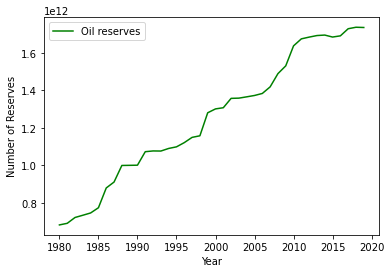

In [28]:
plt.plot(df1['Year'], df2['Oil - Proved reserves'], label = "Oil reserves",color='green')
plt.xlabel('Year')
plt.ylabel('Number of Reserves')
plt.legend()
plt.show()

In [29]:
df3=pd.read_csv('global-fossil-fuel-consumption.csv')
df3.head()

,Entity,Code,Year,Coal (TWh; direct energy),Oil (TWh; direct energy),Gas (TWh; direct energy)
0,World,OWID_WRL,1800,97,0,0
1,World,OWID_WRL,1810,128,0,0
2,World,OWID_WRL,1820,153,0,0
3,World,OWID_WRL,1830,264,0,0
4,World,OWID_WRL,1840,356,0,0


In [30]:
df3['Total Energy']=df3['Coal (TWh; direct energy)'] + df3['Oil (TWh; direct energy)'] + df3['Gas (TWh; direct energy)']
df3=df3[df3['Year']>1960]
df3.head()

,Entity,Code,Year,Coal (TWh; direct energy),Oil (TWh; direct energy),Gas (TWh; direct energy),Total Energy
17,World,OWID_WRL,1965,16140,18109,6303,40552
18,World,OWID_WRL,1966,16324,19496,6869,42689
19,World,OWID_WRL,1967,16061,20891,7375,44327
20,World,OWID_WRL,1968,16301,22675,8044,47020
21,World,OWID_WRL,1969,16799,24577,8833,50209


In [31]:
df3=df3.drop(['Code','Coal (TWh; direct energy)','Oil (TWh; direct energy)','Gas (TWh; direct energy)'],axis=1)
df3=df3.reset_index(drop=True)
df3.head()

,Entity,Year,Total Energy
0,World,1965,40552
1,World,1966,42689
2,World,1967,44327
3,World,1968,47020
4,World,1969,50209


In [35]:
df3['Year']=pd.to_datetime(df3['Year'],format='%Y')
df3=df3.reset_index(drop=True)
df3.head()


,Year,Total Energy
0,1965-01-01,40552
1,1966-01-01,42689
2,1967-01-01,44327
3,1968-01-01,47020
4,1969-01-01,50209


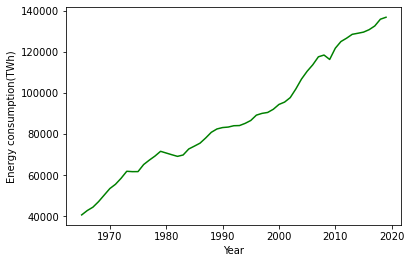

In [33]:
plt.plot(df3['Year'],df3['Total Energy'],color='green')
plt.xlabel('Year')
plt.ylabel('Energy consumption(TWh)')
plt.show()

# Implementing ARIMA model on the data between 1965 and 2019

In [37]:
#df3=df3.drop('Entity',axis=1)
df3.head()

,Year,Total Energy
0,1965-01-01,40552
1,1966-01-01,42689
2,1967-01-01,44327
3,1968-01-01,47020
4,1969-01-01,50209


In [38]:
dfx=pd.read_csv('Xenergy.csv',header=0, index_col=0, parse_dates=True, squeeze=True)
dfx=dfx.drop('Year',axis=1)

# Checking for stationarity of the data

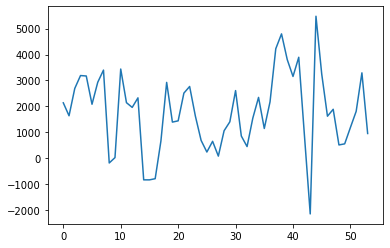

In [39]:
X = dfx.values
diff = list()
for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)
plt.plot(diff)
plt.show()

predicted=119753.893591, expected=116214.000000
predicted=116954.354415, expected=121690.000000
predicted=122916.761129, expected=124940.000000
predicted=125667.552041, expected=126561.000000
predicted=127299.217590, expected=128449.000000
predicted=129356.593177, expected=128962.000000
predicted=130151.494335, expected=129517.000000
predicted=130301.699049, expected=130705.000000
predicted=131256.966857, expected=132514.000000
predicted=133039.961704, expected=135807.000000
predicted=136476.259702, expected=136761.000000
Test RMSE: 2157.641


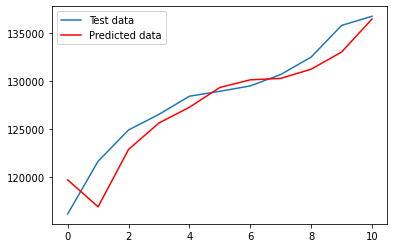

In [40]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
X = dfx.values


size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test,label='Test data')
plt.plot(predictions, color='red',label='Predicted data')
plt.legend()
plt.show()


In [41]:
from sklearn import metrics
print('MSE: ', metrics.mean_squared_error(test, predictions))
print('MAE: ', metrics.mean_absolute_error(test, predictions))
print('R2: ', metrics.r2_score(test, predictions))

MSE:  4655416.263508021
MAE:  1643.928055927893
R2:  0.8567335860859923


# Analysis done for coal reserves and its consumption

In [223]:
coal=pd.read_csv('coal-proved-reserves.csv')
coal.head()

,Entity,Code,Year,Coal - Reserves - Total
0,Asia Pacific,NaN,2020,4.597500e+11
1,Australia,AUS,2020,1.502270e+11
2,Brazil,BRA,2020,6.596000e+09
3,Bulgaria,BGR,2020,2.366000e+09
4,CIS,NaN,2020,1.906550e+11


In [224]:
coal=coal.drop(['Code','Year'],axis=1)
coal.head()

,Entity,Coal - Reserves - Total
0,Asia Pacific,4.597500e+11
1,Australia,1.502270e+11
2,Brazil,6.596000e+09
3,Bulgaria,2.366000e+09
4,CIS,1.906550e+11


In [226]:
coal.sort_values('Coal - Reserves - Total',inplace=True,ascending=False)
coal=coal.reset_index(drop=True)
coal.head()

,Entity,Coal - Reserves - Total
0,World,1.074108e+12
1,Asia Pacific,4.597500e+11
2,North America,2.567340e+11
3,United States,2.489410e+11
4,CIS,1.906550e+11


In [232]:
coal=coal[(coal['Entity']!='World') & (coal['Entity']!='Europe') & (coal['Entity']!='Asia Pacific') & (coal['Entity']!='North America') & (coal['Entity']!='CIS')]
coal.head()

,Entity,Coal - Reserves - Total
3,United States,2.489410e+11
5,Russia,1.621660e+11
6,Australia,1.502270e+11
7,China,1.431970e+11
9,India,1.110520e+11


In [233]:
coal=coal.iloc[0:5,:]
coal

,Entity,Coal - Reserves - Total
3,United States,2.489410e+11
5,Russia,1.621660e+11
6,Australia,1.502270e+11
7,China,1.431970e+11
9,India,1.110520e+11


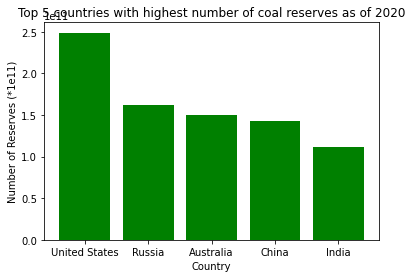

In [237]:
plt.bar('Entity','Coal - Reserves - Total',data=coal,color='green')
plt.title('Top 5 countries with highest number of coal reserves as of 2020')
plt.xlabel('Country')
plt.ylabel('Number of Reserves (*1e11)')
plt.show()

In [238]:
y1=y1.reset_index(drop=True)
y1.head()

,Area,Population,GDP,Renewables (% sub energy),energy_prod_change_twh
0,2.381740e+06,2.560932e+07,6.831043e+10,0.893071,23.21
1,2.736690e+06,3.251555e+07,2.069786e+11,9.478679,9.46
2,7.683110e+06,1.724422e+07,4.656506e+11,4.861643,82.47
3,8.257123e+04,7.862501e+06,1.826247e+11,27.932536,0.00
4,8.300672e+04,7.105890e+06,2.838087e+10,3.124861,9.64


# Linear regression implementation based on best features 

In [239]:
y1=y1.drop('Renewables (% sub energy)',axis=1)
y1.head()

,Area,Population,GDP,energy_prod_change_twh
0,2.381740e+06,2.560932e+07,6.831043e+10,23.21
1,2.736690e+06,3.251555e+07,2.069786e+11,9.46
2,7.683110e+06,1.724422e+07,4.656506e+11,82.47
3,8.257123e+04,7.862501e+06,1.826247e+11,0.00
4,8.300672e+04,7.105890e+06,2.838087e+10,9.64


In [240]:
X=y1[['Area','Population','GDP']]
y=y1[['energy_prod_change_twh']]

In [241]:
len(X)

72

In [242]:
X_train=X.iloc[0:60,:]
X_test=X.iloc[61:72,:]
y_train=y.iloc[0:60,:]
y_test=y.iloc[61:72,:]

In [249]:
y_test=y_test.reset_index(drop=True)

In [244]:
reg = LinearRegression()

# Fit the training data
reg.fit(X_train, y_train)

# Make predictions on the test data
lr_pred = reg.predict(X_test)

In [245]:
print('MSE: ', metrics.mean_squared_error(y_test, lr_pred))
print('MAE: ', metrics.mean_absolute_error(y_test, lr_pred))
print('R2: ', metrics.r2_score(y_test, lr_pred))

MSE:  46612.366544388286
MAE:  93.63365594037465
R2:  0.7712725485418943


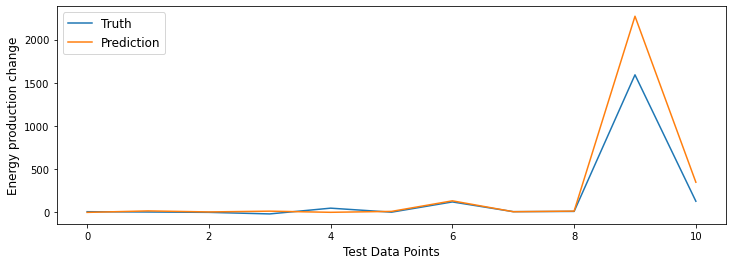

In [250]:
plt.figure(figsize=(12,4))
plt.plot(y_test, label='Truth')
plt.plot(lr_pred, label='Prediction')
plt.ylabel('Energy production change', fontsize=12)
plt.xlabel('Test Data Points', fontsize=12)
plt.legend(fontsize=12)
plt.show()

# Countries with the best renewable energy Production %

In [255]:
renewable_energy.sort_values('Renewables (% sub energy)',inplace=True,ascending=False)
renewable_energy=renewable_energy.reset_index(drop=True)
renewable_energy.head()

,Country Name,Renewables (% sub energy)
0,Norway,66.573732
1,Iceland,60.325089
2,New Zealand,37.884482
3,Brazil,36.887750
4,Sweden,32.283554
